# Natural Language Processing on Clinical Notes 

Data source: 
https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions
<hr> 

### Read Input File & Create Dataframe

In [1]:
import spacy
import medspacy
from medspacy.ner import TargetMatcher, TargetRule
from medspacy.visualization import visualize_ent, visualize_dep
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# read input file 
df = pd.read_csv('input-mtsamples.csv')
df.rename(columns={df.columns[0]: "id"}, inplace=True)
#print(df.describe())
#print(df.head())

# limit to fewer rows
filered_df = df[0:100] 
filered_df = filered_df.reset_index(drop=True)
transcription_text = filered_df["transcription"].to_dict()
#print(transcription_text)
print(filered_df.describe())


               id
count  100.000000
mean    49.500000
std     29.011492
min      0.000000
25%     24.750000
50%     49.500000
75%     74.250000
max     99.000000


<hr>  
   
## Named Entity Recognition   
   
<hr>       

### Setup Medspacy Model & Targets

In [2]:
# load default medspacy model
nlp = medspacy.load()

# set conditions and treatments to identify in text
target_matcher = nlp.get_pipe("medspacy_target_matcher")
target_rules = [
    TargetRule("pregnant", "PROBLEM"),
    TargetRule("stroke", "PROBLEM"),    
    TargetRule("cancer", "PROBLEM"),    
    TargetRule("pain", "PROBLEM"),     
    TargetRule("diabetes", "PROBLEM", pattern=[{"LOWER": {"IN": ["diabetic", "diabetes"]}}]),
    TargetRule("hypertension", "PROBLEM"),       
    TargetRule("insulin", "MEDICATION"),       
    TargetRule("percocet", "MEDICATION")         
]
target_matcher.add(target_rules)

### Named Entity Recognition on a Single Patient's Notes
 - Identify notes that mention the specified target conditions or treatments

In [3]:
text = str(transcription_text[2])
doc = nlp(text)
print("Target Entities Found:", doc.ents)
print("-------------------------------")
for ent in doc.ents:
    if any([ent._.is_negated, ent._.is_uncertain, ent._.is_historical, ent._.is_family, ent._.is_hypothetical, ]):
        print("'{0}' modified by {1}".format(ent, ent._.modifiers))
        print()
print("-------------------------------")
medspacy.visualization.visualize_ent(doc)

Target Entities Found: (diabetic, pain, pain, pain, pain, diabetes, hypertension, stroke, pain, pain, cancer)
-------------------------------
'diabetes' modified by (<ConTextModifier> [379, 380, FAMILY], <ConTextModifier> [380, 381, HISTORICAL])

'hypertension' modified by (<ConTextModifier> [392, 393, FAMILY], <ConTextModifier> [393, 394, HISTORICAL])

'stroke' modified by (<ConTextModifier> [392, 393, FAMILY], <ConTextModifier> [393, 394, HISTORICAL])

'pain' modified by (<ConTextModifier> [618, 619, NEGATED_EXISTENCE],)

'pain' modified by (<ConTextModifier> [666, 667, NEGATED_EXISTENCE],)

'cancer' modified by (<ConTextModifier> [666, 667, NEGATED_EXISTENCE],)

-------------------------------


### Named Entity Recognition on a List of Patient's Notes 
 - Identify notes that mention the specified target conditions or treatments

In [4]:
results = []
for i in transcription_text:
    # run model on row
    text = str(transcription_text[i])
    doc = nlp(text)
    
    # identify unique targets found that were not negated, family history, or hypothetical
    found = set()
    for ent in doc.ents:      
        if not any([ent._.is_negated, ent._.is_family, ent._.is_hypothetical]):
            if str(ent).lower() == 'diabetic':
                found.add('diabetes')
            else: 
                found.add(str(ent).lower())
    
    if len(found) <1:
        results.append("NA")
    else:
        results.append(found)
    
    #print('----- Patient', i+1, '-----')
    #print("----- Target Entities Found:", found)
    #medspacy.visualization.visualize_ent(doc)
    
print('----- Full Results -----')
print("Target Entities Found:", results)

----- Full Results -----
Target Entities Found: ['NA', {'pain'}, {'diabetes', 'pain'}, 'NA', {'hypertension'}, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', {'cancer'}, {'pain', 'hypertension'}, 'NA', 'NA', 'NA', 'NA', 'NA', {'diabetes', 'hypertension'}, {'cancer'}, {'pain', 'hypertension'}, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', {'pain'}, 'NA', {'insulin', 'hypertension'}, 'NA', 'NA', {'stroke'}, {'pain'}, 'NA', 'NA', {'cancer', 'pain'}, {'pain'}, 'NA', {'pain'}, 'NA', 'NA', {'pain'}, 'NA', 'NA', 'NA', 'NA', 'NA', {'cancer'}, {'cancer'}, 'NA', 'NA', 'NA', 'NA', 'NA', {'cancer'}, {'cancer', 'pain'}, 'NA', 'NA', {'pain'}, 'NA', 'NA', {'cancer', 'stroke'}, 'NA', 'NA', {'diabetes', 'hypertension'}, {'pain', 'hypertension'}, 'NA', {'pain'}, 'NA', {'pain'}, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', {'pain'}, 'NA', {'pain'}, {'stroke'}, 'NA', 'NA', {'pain'}, {'pain'}, 'NA', {'pain'}, {'pain'}, {'pain'}, 'NA', 'NA', 'NA', 'NA', 'NA', 'NA', {'pain'}, {'pain'}]


### Save Target Results

In [5]:
df_results = filered_df
df_results['targets_identified'] = results 
df_results['targets_identified'] = df_results['targets_identified'].astype(str).str.strip('{|}')
df_results['targets_identified'] = df_results['targets_identified'].str.replace("\'","")

# flag conditions with one-hot encoding 
df_results['pain_flag'] = df_results['targets_identified'].str.contains('pain')
df_results['cancer_flag'] = df_results['targets_identified'].str.contains('cancer')
df_results['diabetes_flag'] = df_results['targets_identified'].str.contains('diabetes')
df_results['stroke_flag'] = df_results['targets_identified'].str.contains('stroke')
df_results['pregnant_flag'] = df_results['targets_identified'].str.contains('pregnant')
df_results['hypertension_flag'] = df_results['targets_identified'].str.contains('hypertension')

df_results['pain_flag'] = df_results['pain_flag'].astype(int)
df_results['cancer_flag'] = df_results['cancer_flag'].astype(int)
df_results['diabetes_flag'] = df_results['diabetes_flag'].astype(int)
df_results['stroke_flag'] = df_results['stroke_flag'].astype(int)
df_results['pregnant_flag'] = df_results['pregnant_flag'].astype(int)
df_results['hypertension_flag'] = df_results['hypertension_flag'].astype(int)

df_results.to_csv('output-with-targets.csv', index=False)
#print(df_results['targets_identified'])

### Chart Results

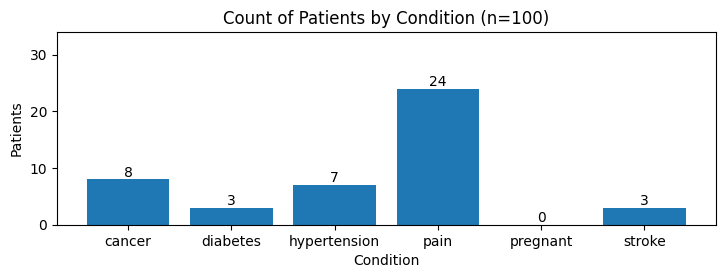

In [6]:
# create a chart to view results
pain_tot = df_results['pain_flag'].sum()
cancer_tot = df_results['cancer_flag'].sum()
diabetes_tot = df_results['diabetes_flag'].sum()
stroke_tot = df_results['stroke_flag'].sum()
pregnant_tot = df_results['pregnant_flag'].sum()
hypertension_tot = df_results['hypertension_flag'].sum()
total = df_results['id'].count()

b = [cancer_tot, diabetes_tot, hypertension_tot, pain_tot, pregnant_tot, stroke_tot]
l = ['cancer', 'diabetes', 'hypertension', 'pain', 'pregnant', 'stroke']

plt.rcParams["figure.figsize"] = (8.5,2.5)
plt.bar(l, b)
plt.ylim(0, max(b)+10)
plt.title('Count of Patients by Condition (n='+str(total)+')')
plt.xlabel("Condition")
plt.ylabel("Patients")
plt.savefig('conditions_chart.png', bbox_inches='tight')
for i in range(len(b)):
    plt.annotate(str(b[i]), xy=(l[i],b[i]), ha='center', va='bottom')

plt.show()

<hr>  
   
## Summarization  
   
<hr>        

### Summarize One Patient's Notes Using Lemmatization

LIST OF SENTENCE SCORES USING LEMMAS:
 [0.08333, 0.11765, 0.0, 0.0, 0.2, 0.0, 0.0, 0.25, 0.05, 0.08333, 0.14286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.15385, 0.0, 0.08333, 0.16667]


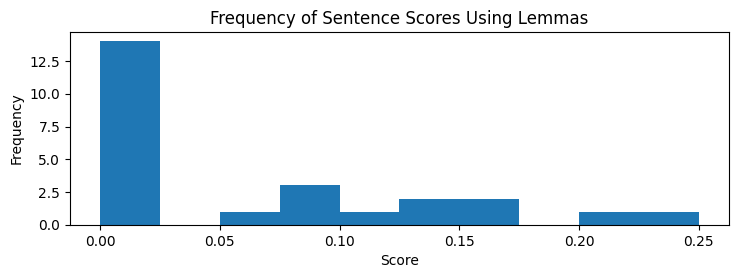

In [7]:
# load text into trained spaCy pipeline
nlp = spacy.load('en_core_web_sm')
doc = nlp(transcription_text[0])

# create a function to remove whitepace, stopwords, and punctuation
def we_care_about(token):
    return not (token.is_space or token.is_punct or token.is_stop)

# remove whitespace, stopwords, and punctuation & make text lowercase
interesting_lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]

# count lemma frequency 
lemma_freq = Counter(interesting_lemmas)

# find most common lemmas
top_lemmas = set()
for l, freq in lemma_freq.most_common(5):
    top_lemmas.add(l)

# count number of lemmas in each sentence
sentences = list(doc.sents)
sentence_score_list = list()
for sentence in sentences:
    important_count = 0
    total_count = 0
    
    for lem in sentence:
        #count important lemmas in sentence
        if lem.lemma_.lower() in top_lemmas:
            important_count += 1
        
        #count total lemmas in sentence
        if not(lem.is_space or lem.is_punct):
            total_count += 1
    
    score = 0 if total_count == 0 else round(important_count/total_count, 5)
    sentence_score_list.append(score)
    
print("LIST OF SENTENCE SCORES USING LEMMAS:\n", sentence_score_list)

# plot a histogram with sentence scores
plt.hist(sentence_score_list)
plt.title('Frequency of Sentence Scores Using Lemmas')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

In [8]:
# create a summary by adding each sentence to a list if score > cutoff 
cutoff_score = 0.05

lemma_summary_list = list()
sent_count_summary = 0
sent_count_original = 0

for sent in sentences:
    important_count = 0
    total_count = 0
    sent_count_original+=1
    
    for lem in sent:
        #count important words in sentence
        if lem.lemma_.lower() in top_lemmas:
            important_count += 1
        
        #count total words in sentence
        if not(lem.is_space or lem.is_punct):
            total_count += 1
    
    score = 0 if total_count == 0 else round(important_count/total_count, 5)
    
    if score > cutoff_score:
        lemma_summary_list.append(sent) 
        sent_count_summary +=1
        
print("TRANSCRIPTION:\n-----------------------------")
print("ORIGINAL:\n", doc)
print(">>>>> SENTENCE COUNT:", sent_count_original)
print("-----------------------------")
print("SUMMARY:\n"+ ' '.join(str(s) for s in lemma_summary_list))
print(">>>>> SENTENCE COUNT:", sent_count_summary)

TRANSCRIPTION:
-----------------------------
ORIGINAL:
 SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was se

### Summarize a List of Patient's Notes Using Lemmatization

In [9]:
# create a function to remove whitepace, stopwords, and punctuation
def we_care_about(token):
    return not (token.is_space or token.is_punct or token.is_stop)

nlp = spacy.load('en_core_web_sm')
 
cutoff_score = 0.05

all_scores = []
all_summary = []

for r in transcription_text:

    # load text into trained spaCy pipeline
    text = str(transcription_text[r])
    doc = nlp(text)

    # remove whitespace, stopwords, and punctuation & make text lowercase
    interesting_lemmas = [token.lemma_.lower() for token in doc if we_care_about(token)]

    # count lemma frequency 
    lemma_freq = Counter(interesting_lemmas)

    # find most common lemmas
    top_lemmas = set()
    for l, freq in lemma_freq.most_common(5):
        top_lemmas.add(l)

    # count number of lemmas in each sentence
    sentences = list(doc.sents)
    
    sentence_score_list = list()
    lemma_summary_list = list()
    
    sent_count_summary = 0
    sent_count_original = 0

    for sentence in sentences:
        important_count = 0
        total_count = 0

        for lem in sentence:
            #count important lemmas in sentence
            if lem.lemma_.lower() in top_lemmas:
                important_count += 1

            #count total lemmas in sentence
            if not(lem.is_space or lem.is_punct):
                total_count += 1

        score = 0 if total_count == 0 else round(important_count/total_count, 5)
        sentence_score_list.append(score)

        if score > cutoff_score:
            lemma_summary_list.append(sentence) 
            sent_count_summary +=1
        
        sent_count_original+=1
        
    all_scores.append(sentence_score_list)
    all_summary.append(''.join(str(s) for s in lemma_summary_list))

#print(all_summary)

### Save Summary Results

In [10]:
df_summary = df_results
df_summary['note_summary'] = all_summary 
df_summary['note_summary'] = df_summary['note_summary'].astype(str).str.strip('[|]')

df_results.to_csv('output-with-summary.csv', index=False)
print(df_summary['note_summary'])

0     SUBJECTIVE:,  This 23-year-old white female pr...
1     PAST MEDICAL HISTORY:, He has difficulty climb...
2     HISTORY OF PRESENT ILLNESS: , I have seen ABC ...
3     2-D M-MODE: , ,1.  Left atrial enlargement wit...
4     The left ventricular cavity size and wall thic...
                            ...                        
95    PREOPERATIVE DIAGNOSIS: , Inguinal hernia.,POS...
96    ,A standard inguinal incision was made and dis...
97                                                  nan
98    PREOPERATIVE DIAGNOSIS:,  Bilateral inguinal h...
99    PREOPERATIVE DIAGNOSIS: , Right inguinal herni...
Name: note_summary, Length: 100, dtype: object
